In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.stats import kurtosis, skew
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [ ]:
#Training set organization
train_bcc= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [ ]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [ ]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

2713
2713
2632
498
678
94


In [ ]:
#Training set DataFrame construction
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [ ]:
#Validation set DataFrame construction
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [ ]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [ ]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [ ]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [ ]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [ ]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/X_train.p', 'wb') as fp:
  pickle.dump(X_train, fp)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/X_val.p', 'wb') as fp:
  pickle.dump(X_test, fp)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/y_train.p', 'wb') as fp:
  pickle.dump(y_train, fp)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/y_val.p', 'wb') as fp:
  pickle.dump(y_test, fp)

In [ ]:
def color_histogram_features(imr):
  color_histogram=[]
  for i in imr:
    image_read= cv2.imread(i)
    bgr= cv2.split(image_read)
    histSize=64
    histRange=(0,256)
    accumulate= False 
    b_hist = cv2.calcHist(bgr, [0], None, [histSize], histRange)
    g_hist = cv2.calcHist(bgr, [1], None, [histSize], histRange)
    r_hist = cv2.calcHist(bgr, [2], None, [histSize], histRange)
    bgr_hist= np.concatenate((b_hist,g_hist,r_hist),axis=None).T
    color_histogram.append(bgr_hist)
  
  features_color_histogram= pd.DataFrame(color_histogram)
  
  return features_color_histogram

In [ ]:
X_train_features = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Train_HistogramColorFeatures291022.csv')
X_test_features = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Test_HistogramColorFeatures291022.csv')

In [ ]:
# X_train_features= color_histogram_features(X_train)
# X_test_features= color_histogram_features(X_test)
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

In [ ]:
# X_train_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Train_HistogramColorFeatures291022.csv',index=False)
# X_test_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/Test_HistogramColorFeatures291022.csv',index=False)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
pickle.dump(model1, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/ColorHistSVM_model.sav', 'wb'))

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       678
           1       0.71      0.71      0.71       498
           2       0.23      0.56      0.33        94

    accuracy                           0.71      1270
   macro avg       0.62      0.67      0.62      1270
weighted avg       0.78      0.71      0.73      1270

0.6672706012652884
Kappa Score :
0.5180473275678159


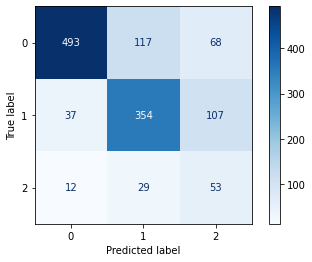

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68       678
           1       0.63      0.63      0.63       498
           2       0.14      0.40      0.21        94

    accuracy                           0.59      1270
   macro avg       0.52      0.54      0.50      1270
weighted avg       0.69      0.59      0.62      1270

0.5402439482400827
Kappa Score :
0.3412363688597524


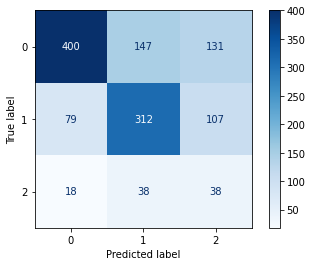

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       678
           1       0.73      0.70      0.71       498
           2       0.28      0.59      0.38        94

    accuracy                           0.73      1270
   macro avg       0.63      0.69      0.64      1270
weighted avg       0.77      0.73      0.75      1270

0.6859430441278073
Kappa Score :
0.5420955480431235


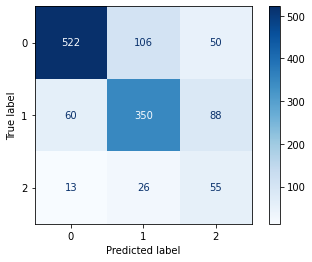

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model3, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/ColorHistGBoost_model.sav', 'wb'))

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       678
           1       0.79      0.81      0.80       498
           2       0.45      0.57      0.50        94

    accuracy                           0.81      1270
   macro avg       0.71      0.74      0.73      1270
weighted avg       0.82      0.81      0.82      1270

0.7436152694629645
Kappa Score :
0.6678085190211444


In [ ]:
pickle.dump(model4, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/ColorHistRF_model.sav', 'wb'))

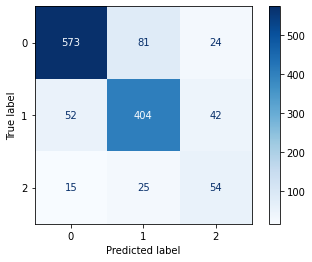

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       678
           1       0.68      0.61      0.64       498
           2       0.16      0.36      0.22        94

    accuracy                           0.65      1270
   macro avg       0.55      0.57      0.54      1270
weighted avg       0.71      0.65      0.68      1270

0.5653079902614285
Kappa Score :
0.41498076129414163


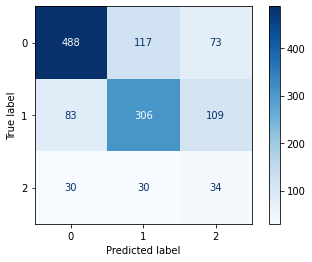

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.82      0.70      0.75       678
           1       0.68      0.63      0.65       498
           2       0.22      0.53      0.31        94

    accuracy                           0.66      1270
   macro avg       0.57      0.62      0.57      1270
weighted avg       0.72      0.66      0.68      1270

0.6213643880738545
Kappa Score :
0.43446735352583576


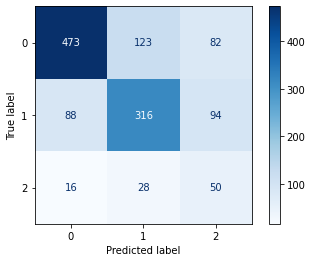

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       678
           1       0.71      0.68      0.70       498
           2       0.24      0.51      0.32        94

    accuracy                           0.71      1270
   macro avg       0.61      0.65      0.61      1270
weighted avg       0.76      0.71      0.73      1270

0.6508077121137533
Kappa Score :
0.5121969088047156


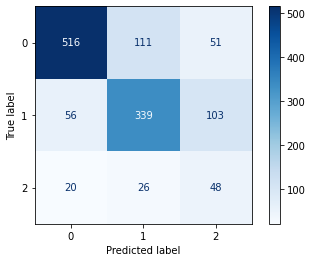

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70       678
           1       0.64      0.50      0.56       498
           2       0.00      0.00      0.00        94

    accuracy                           0.61      1270
   macro avg       0.42      0.43      0.42      1270
weighted avg       0.59      0.61      0.59      1270

0.42822025565388394
Kappa Score :
0.2646982211529353


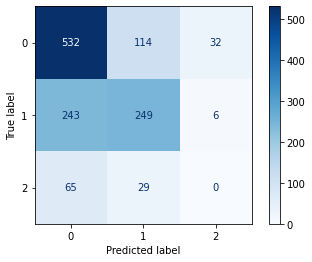

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       678
           1       0.70      0.64      0.67       498
           2       0.26      0.66      0.37        94

    accuracy                           0.69      1270
   macro avg       0.60      0.67      0.61      1270
weighted avg       0.75      0.69      0.71      1270

0.674105825171016
Kappa Score :
0.47884870126130274


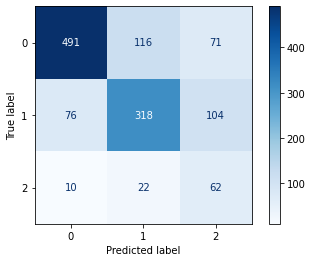

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       678
           1       0.79      0.80      0.79       498
           2       0.41      0.62      0.49        94

    accuracy                           0.80      1270
   macro avg       0.70      0.75      0.71      1270
weighted avg       0.82      0.80      0.80      1270

0.7457396270577824
Kappa Score :
0.6475544018175692


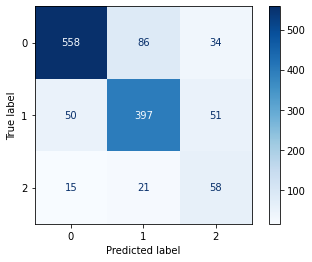

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       678
           1       0.81      0.82      0.82       498
           2       0.52      0.57      0.55        94

    accuracy                           0.83      1270
   macro avg       0.74      0.76      0.75      1270
weighted avg       0.83      0.83      0.83      1270

0.755633845241003
Kappa Score :
0.69599446779084


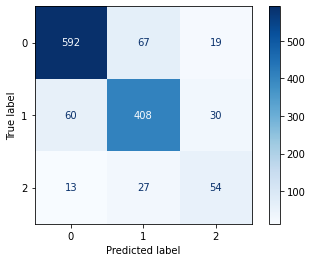

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()